In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="logs")

import math, copy, time
import os
import pandas as pd
import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import generate_dataset
import lstm_encoder_decoder
import plotting 

## Import Dataset

### Dataset 1

In [15]:
pre = os.path.dirname(os.path.abspath('__file__'))
post = 'testPuneAQMNew_22.csv'
full_path = os.path.join(pre,post)
df = pd.read_csv(full_path)

In [16]:
print("DataFrame = {} rows {} columns".format(*df.shape))
display(df.head())

DataFrame = 16477 rows 19 columns


,airQualityLevel,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime
0,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94
1,MODERATE,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94
2,SEVERE,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94
3,VERY_POOR,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94
4,VERY_POOR,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94


In [17]:
airQualityLevel_dict = {'SATISFACTORY': 1, 'MODERATE': 2, 'POOR': 3, 'VERY_POOR': 4, 'SEVERE': 5}
df['airQualityLevel_encod'] = df.airQualityLevel.map(airQualityLevel_dict)
df = df.drop(['airQualityLevel'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0
1,2022-01-01 00:01:08+05:30,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0
3,2022-01-01 00:01:08+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0
4,2022-01-01 00:01:09+05:30,ACTIVE,PM2.5,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0


In [18]:
aqiMajorPollutant_dict = {'PM2.5': 1, 'CO': 2, 'NO2': 3}
df['aqiMajorPollutant_encod'] = df.aqiMajorPollutant.map(aqiMajorPollutant_dict)
df = df.drop(['aqiMajorPollutant'], axis=1)
display(df.head())

,observationDateTime,deviceStatus,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,airQualityLevel_encod,aqiMajorPollutant_encod
0,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,349.0,0.0,0.25,201.40,566.82,305.35,3.67,111.35,21.54,1.24,76.16,4.04,77.90,0.94,4.0,1.0
1,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,103.0,0.0,29.70,2.96,0.00,3.78,3.36,51.81,19.91,4.08,78.80,3.78,77.22,0.94,2.0,2.0
2,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,408.0,0.0,0.00,328.16,675.62,487.34,3.17,58.84,20.79,1.16,62.37,0.21,77.25,0.94,5.0,1.0
3,2022-01-01 00:01:08+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,306.0,0.0,0.00,154.19,73.23,223.55,4.78,68.58,21.54,2.79,77.73,3.62,73.87,0.94,4.0,1.0
4,2022-01-01 00:01:09+05:30,ACTIVE,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,366.0,0.0,0.00,222.11,315.10,335.07,2.37,64.17,20.91,4.51,75.95,3.13,76.85,0.94,4.0,1.0


In [19]:
features_considered = ['airQualityLevel_encod', 'aqiMajorPollutant_encod','airQualityIndex','uv.avgOverTime',
                       'o3.avgOverTime','pm2p5.avgOverTime','co2.avgOverTime','pm10.avgOverTime','co.avgOverTime','no2.avgOverTime',
                       'airTemperature.avgOverTime','illuminance.avgOverTime','ambientNoise.avgOverTime','so2.avgOverTime',
                       'relativeHumidity.avgOverTime','atmosphericPressure.avgOverTime']
features = df[features_considered]
features.index = df['observationDateTime']

In [20]:
dataset1 = features.values
print(f"Shape : {dataset1.shape}, Data Type : {dataset1.dtype}")

Shape : (16477, 16), Data Type : float64


### Dataset 2 

In [21]:
x = torch.tensor([2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 18, 17, 15, 14, 12, 11, 9, 8, 6, 5, 3, 2, 0, 1]).view(27,1)
y = torch.tensor([1]).view(1,1)
for i in range(100):
    y = torch.cat((y,x), dim=0)

for j in range(2):
    y = torch.cat((y,y), dim=1)

y.shape

torch.Size([2701, 4])

In [22]:
dataset2 = y.numpy().astype(np.float64)
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (2701, 4), Data Type : float64


<function matplotlib.pyplot.show(close=None, block=None)>

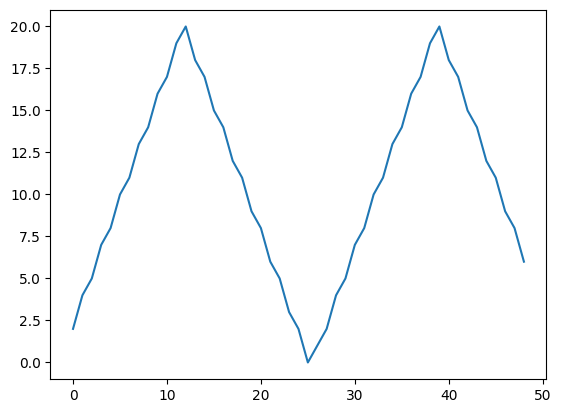

In [23]:
plt.plot(dataset2[1:50,2])
plt.show

### Corrupt Data

<function matplotlib.pyplot.show(close=None, block=None)>

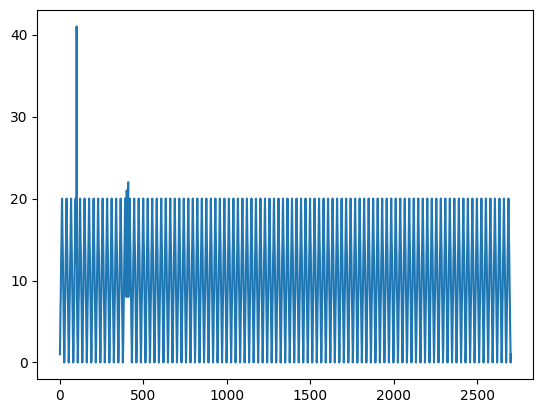

In [24]:
dataset2[100:102] += 30
dataset2[400:410] += 15
plt.plot(dataset2[:,2])
plt.show

## Training And Validation Data

In [25]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [26]:
train_split = 1000
lookback = 20
lookahead = 10
step = 1
batch_size = 45

x_train_multi, y_train_multi = multivariate_data(dataset2, dataset2, 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi, y_val_multi = multivariate_data(dataset2, dataset2,
                                             train_split, 1500, lookback,
                                             lookahead, step)

print (x_train_multi.shape,
       y_train_multi.shape,
       'Input size : {}'.format(x_train_multi[0].shape),
       'Target size to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(980, 20, 4)
(980, 10, 4)
Input size : (20, 4)
Target size to predict : (10, 4)


In [27]:
#Extracting a single column for univariante time series
x_train = torch.from_numpy(x_train_multi[:,:,2])
y_train = torch.from_numpy(y_train_multi[:,:,2])
x_valid = torch.from_numpy(x_val_multi[1:100,:,2])
y_valid = torch.from_numpy(y_val_multi[1:100,:,2])

x_valid = torch.unsqueeze(x_valid,2)
x_valid = x_valid.transpose(1,0).float()

y_valid = torch.unsqueeze(y_valid,2)
y_valid = y_valid.transpose(1,0).float()
print(f"X Train Shape : {x_train.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"X Valid Shape : {x_valid.shape}")
print(f"Y Valid Shape : {y_valid.shape}")

X Train Shape : torch.Size([980, 20])
Y Train Shape : torch.Size([980, 10])
X Valid Shape : torch.Size([20, 99, 1])
Y Valid Shape : torch.Size([10, 99, 1])


## Functions

In [28]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [29]:
class FeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff, bias=True)
        self.w_2 = nn.Linear(d_ff, d_model, bias=True)
        #self.dropout = nn.Dropout(dropout)
        #self.norm = LayerNorm(d_model)

    def forward(self, x):
        return self.w_2(F.relu(self.w_1(x.to(torch.float32))))

In [30]:
def SpecialConcat(input1, input2):
    "If all are zero it returns true"
    if not (torch.is_nonzero(torch.any(input1))):
        return input2
    return torch.cat((input1, input2), 1)

In [31]:
def MovingBatch(x_train, y_train, time_window_size, T):
    return x_train[T:T+time_window_size], y_train[T:T+time_window_size]

In [32]:
g = torch.Generator().manual_seed(2147483647)

## Modules

In [33]:
# class Data_Valuator_MLP(nn.Module):
#     def __init__(self, d_model, d_ff):
#         "d_model is same as lookback"
#         super(Data_Valuator_MLP, self).__init__()

#         self.layers1 = clones(FeedForward(d_model, d_ff), 2)
#         self.layers2 = clones(FeedForward(d_model, 32), 1)
#         self.layers3 = clones(FeedForward(d_model, 16), 1)
#         self.layers4 = clones(FeedForward(d_model, 8), 1)
#         self.prob = nn.Linear(d_model, 1, bias = True)

#     def forward(self, x):
#         for layers in self.layers1:
#             x = layers(x)         #b
#         for layers in self.layers2:
#             x = layers(x)
#         for layers in self.layers3:
#             x = layers(x)
#         for layers in self.layers4:
#             x = layers(x)
#         return F.sigmoid(self.prob(x))

In [34]:
class Data_Valuator_MLP(nn.Module):
    def __init__(self, d_model, d_ff):
        "d_model is same as lookback"
        super(Data_Valuator_MLP, self).__init__()

        self.layer = nn.Sequential(
                        nn.Linear(d_model, d_ff, bias = True),
                        nn.ReLU(),
                        nn.Linear(d_ff, 128, bias = True),
                        nn.ReLU(),
                        nn.Linear(128, 64, bias = True),
                        nn.ReLU(),
                        nn.Linear(64, 32, bias = True),
                        nn.ReLU(),
                        nn.Linear(32, 16, bias = True),
                        nn.ReLU(),
                        nn.Linear(16, 1, bias = True),
                        nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x.to(torch.float32))

In [35]:
def SelectionFromProb(prob):
    return torch.bernoulli(prob, generator = g)

In [36]:
def SelectBatches(x, y, prob):
    #Generate The Batch
    x_bat_zero = x*prob
    y_bat_zero = y*prob

    #Removing The Zeroes
    x_non_empty_mask = x_bat_zero.abs().sum(dim=1).bool()
    y_non_empty_mask = y_bat_zero.abs().sum(dim=1).bool()

    x_batch = x_bat_zero[x_non_empty_mask,:]
    y_batch = y_bat_zero[y_non_empty_mask,:]

    return x_batch, y_batch

In [37]:
# class DataValuator(nn.ModuleList):
#     def __init__(self, data_valuator_mlp):
#         super(DataValuator, self).__init__()
#         self.data_valuator_mlp = data_valuator_mlp

#     def forward(self, x, y):
#         input = torch.cat((x,y), 1)
#         prob = self.data_valuator_mlp(input)
#         select = SelectionFromProb(prob)
#         #prob.requires_grad = False
#         x1, y1 = SelectBatches(x, y, select)
#         return x1, y1, select, prob

In [38]:
x = torch.tensor([1, 1], dtype=torch.float32, requires_grad=True)
y = torch.tensor([1, 1], dtype=torch.float32, requires_grad=True)
input = torch.cat((x,y), 0)
w = input.mean()
w.backward()
print(x.grad)

tensor([0.2500, 0.2500])


In [39]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 64):
    "Helper: Construct a model from hyperparameters."
    #c = copy.deepcopy
    #data_valuator_mlp = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    model_1 = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

## Losses

In [40]:
def MAL(val_loss, T, prev_avg):
    return ((T-1.0)/T)*prev_avg + (1/T)*val_loss

In [41]:
def DataValuator_LogPi(selection_vector, prob_vector):
    log_pi_list = []
    for i in range(selection_vector.shape[0]):
        if torch.is_nonzero(selection_vector[i] == 1):
            log_pi_list.append(prob_vector[i].log())
        else:
            log_pi_list.append((1 - prob_vector[i]).log())
    log_pi = torch.sum(torch.stack(log_pi_list))
    return log_pi

In [42]:
def DataValuator_Train(model, log_pi, reward):
    log_pi.backward()
    for p in model.parameters():
        p.data.add(reward * p.grad.data, alpha=0.5)  #Beta = 0.001
        if p.grad is not None:
            p.grad.zero_()
    return 0

## Forward And Backward Pass

In [43]:
model_1 = make_model()
moving_avg_loss = 0
criterion = nn.MSELoss()

In [44]:
torchinfo.summary(model_1, [(batch_size, lookback + lookahead)], dtypes=[torch.float64, torch.float64], col_names=["input_size", "output_size", 
                                                                                                 "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Data_Valuator_MLP                        [45, 30]                  [45, 1]                   --                        True
├─Sequential: 1-1                        [45, 30]                  [45, 1]                   --                        True
│    └─Linear: 2-1                       [45, 30]                  [45, 64]                  1,984                     True
│    └─ReLU: 2-2                         [45, 64]                  [45, 64]                  --                        --
│    └─Linear: 2-3                       [45, 64]                  [45, 128]                 8,320                     True
│    └─ReLU: 2-4                         [45, 128]                 [45, 128]                 --                        --
│    └─Linear: 2-5                       [45, 128]                 [45, 64]                  8,256                     True
│    └─

In [45]:
for p in model_1.parameters():
    p.requires_grad = True #False

time_window_size = 45
reward = -10
mov_avg_plot = []
reward_plot = []
curr_loss_plot = []
iteration = []

In [46]:
for p in model_1.parameters():
    print(p.grad)

None
None
None
None
None
None
None
None
None
None
None
None


In [47]:
reward = 0
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 32)
num_eons = 3
for i in range(num_eons):
    for T in range(1000):
        
        #Make Time Window Batches
        if T == 980:
            break
        x_batch, y_batch = MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1)
        prob_vector = model_1.forward(input)
        select = SelectionFromProb(prob_vector)
        select_for_lstm = select.clone().detach()
        x_selected_batch, y_selected_batch = SelectBatches(x_batch, y_batch, select_for_lstm)
        if torch.all(select==0).item():
            continue
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float()
        #Pass Through LSTM
        loss = model_4.train_model(x_selected_batch, y_selected_batch, n_epochs = 1, target_len = 10, batch_size = x_selected_batch.shape[1], 
                             training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)
        curr_lossi = lstm_encoder_decoder.predict_loss(model_4, x_valid, y_valid)
        curr_loss = torch.tensor(curr_lossi)
        #Update The Moving Average
        moving_avg_loss = MAL(curr_loss, T+1, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = curr_loss - moving_avg_loss
        data_valuator_loss = DataValuator_LogPi(select, prob_vector)
        if torch.eq(reward,0).item():
            reward = torch.tensor(-10)
        #Update The Data Valuator Parameters
        reward_for_data = reward.clone().detach()
        DataValuator_Train(model_1, data_valuator_loss, reward_for_data)
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward)
        curr_loss_plot.append(curr_loss)
        iteration.append(T)
        writer.add_scalar("Loss/curr", curr_loss, T)
        writer.add_scalar("Loss/avg", moving_avg_loss, T)
        if T%100 == 0:
            print(f"curr_loss = {curr_loss}, mov_avg = {moving_avg_loss}, reward = {reward}")

curr_loss = 133.49302673339844, mov_avg = 133.49302673339844, reward = -10
curr_loss = 18.740432739257812, mov_avg = 32.82514953613281, reward = -14.084716796875
curr_loss = 9.315237998962402, mov_avg = 21.695547103881836, reward = -12.380309104919434
curr_loss = 5.091611385345459, mov_avg = 16.542236328125, reward = -11.450624465942383
curr_loss = 18.678462982177734, mov_avg = 16.11008644104004, reward = 2.5683765411376953
curr_loss = 4.958771228790283, mov_avg = 14.144242286682129, reward = -9.185470581054688
curr_loss = 2.306922435760498, mov_avg = 12.459944725036621, reward = -10.153022766113281
curr_loss = 2.2322139739990234, mov_avg = 11.161689758300781, reward = -8.929475784301758
curr_loss = 3.3359620571136475, mov_avg = 10.165467262268066, reward = -6.82950496673584
curr_loss = 2.687262535095215, mov_avg = 9.36677074432373, reward = -6.679508209228516
curr_loss = 2.980140447616577, mov_avg = 2.980140447616577, reward = -10
curr_loss = 1.307098388671875, mov_avg = 6.01977014541

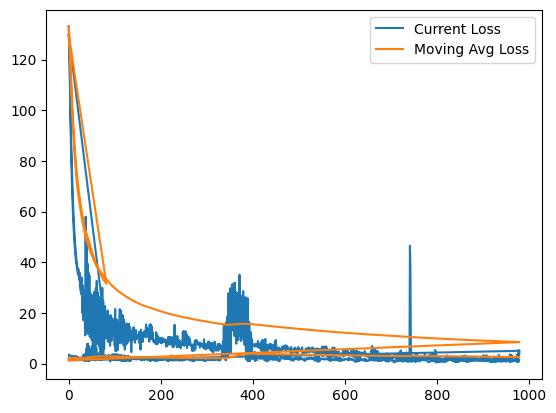

In [39]:
curr_loss_plot_list = [tensor for tensor in curr_loss_plot]
#reward_plot_list = [tensor.item() for tensor in reward_plot]
mov_avg_plot_list = [tensor for tensor in mov_avg_plot]
iteration_plot_list = iteration
plt.plot(iteration, curr_loss_plot_list, label='Current Loss')
plt.plot(iteration, mov_avg_plot_list, label='Moving Avg Loss')
#plt.plot(iteration, reward_plot_list, label='Reward')
#plt.plot(iteration, x_train[0:800,2], label='Dataset')
plt.legend()
plt.show()

## Test Model

In [43]:
data_values = torch.zeros_like(x_train)[:,0].view(len(x_train),1)
data_values.shape

torch.Size([980, 1])

In [44]:
time_window_size = 45
with torch.no_grad():
    for T in range(10000):
        #Make Time Window Batches
        if T == 980:
            break
        x_batch, y_batch = MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1)
        prob_vector = model_1.forward(input)
        data_values[T:len(x_batch)+T]= data_values[T:len(x_batch)+T] + prob_vector

In [45]:
data_values[230:250]

tensor([[21.0761],
        [21.1266],
        [21.1250],
        [21.3022],
        [21.3229],
        [21.4589],
        [21.4199],
        [21.4410],
        [21.2933],
        [21.1933],
        [21.2007],
        [21.3042],
        [21.4331],
        [21.3791],
        [21.3810],
        [21.3234],
        [21.2703],
        [21.1931],
        [20.9894],
        [21.0826]], dtype=torch.float64)

In [46]:
data_values[100:130]

tensor([[21.5705],
        [21.4182],
        [21.4410],
        [21.2933],
        [21.1933],
        [21.2007],
        [21.3042],
        [21.4331],
        [21.3791],
        [21.3810],
        [21.3234],
        [21.2703],
        [21.1931],
        [20.9894],
        [21.0826],
        [21.0455],
        [21.1717],
        [21.1546],
        [21.1080],
        [21.2317],
        [21.2427],
        [21.2589],
        [21.0761],
        [21.1266],
        [21.1250],
        [21.3022],
        [21.3229],
        [21.4589],
        [21.4199],
        [21.4410]], dtype=torch.float64)

In [47]:
data_values[400:460]

tensor([[20.8867],
        [20.6668],
        [20.9672],
        [21.0524],
        [21.1809],
        [21.1209],
        [21.0237],
        [20.8220],
        [21.1568],
        [21.0181],
        [20.9894],
        [21.0826],
        [21.0455],
        [21.1717],
        [21.1546],
        [21.1080],
        [21.2317],
        [21.2427],
        [21.2589],
        [21.0761],
        [21.1266],
        [21.1250],
        [21.3022],
        [21.3229],
        [21.4589],
        [21.4199],
        [21.4410],
        [21.2933],
        [21.1933],
        [21.2007],
        [21.3042],
        [21.4331],
        [21.3791],
        [21.3810],
        [21.3234],
        [21.2703],
        [21.1931],
        [20.9894],
        [21.0826],
        [21.0455],
        [21.1717],
        [21.1546],
        [21.1080],
        [21.2317],
        [21.2427],
        [21.2589],
        [21.0761],
        [21.1266],
        [21.1250],
        [21.3022],
        [21.3229],
        [21.4589],
        [21.

In [64]:
x_batch, y_batch = MovingBatch(x_train, y_train, 45,300)
x_batch[7:10] = 10000
x_batch[0:10]

tensor([[5.0000e+00, 7.0000e+00, 8.0000e+00, 1.0000e+01, 1.1000e+01, 1.3000e+01,
         1.4000e+01, 1.6000e+01, 1.7000e+01, 1.9000e+01, 2.0000e+01, 1.8000e+01,
         1.7000e+01, 1.5000e+01, 1.4000e+01, 1.2000e+01, 1.1000e+01, 9.0000e+00,
         8.0000e+00, 6.0000e+00],
        [7.0000e+00, 8.0000e+00, 1.0000e+01, 1.1000e+01, 1.3000e+01, 1.4000e+01,
         1.6000e+01, 1.7000e+01, 1.9000e+01, 2.0000e+01, 1.8000e+01, 1.7000e+01,
         1.5000e+01, 1.4000e+01, 1.2000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00,
         6.0000e+00, 5.0000e+00],
        [8.0000e+00, 1.0000e+01, 1.1000e+01, 1.3000e+01, 1.4000e+01, 1.6000e+01,
         1.7000e+01, 1.9000e+01, 2.0000e+01, 1.8000e+01, 1.7000e+01, 1.5000e+01,
         1.4000e+01, 1.2000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00, 6.0000e+00,
         5.0000e+00, 3.0000e+00],
        [1.0000e+01, 1.1000e+01, 1.3000e+01, 1.4000e+01, 1.6000e+01, 1.7000e+01,
         1.9000e+01, 2.0000e+01, 1.8000e+01, 1.7000e+01, 1.5000e+01, 1.4000e+01,
       

In [65]:
input2 = torch.cat((x_batch,y_batch), 1)
prob_vector2 = model_1.forward(input2)
prob_vector2

tensor([[0.4727],
        [0.4710],
        [0.4664],
        [0.4685],
        [0.4677],
        [0.4705],
        [0.4701],
        [0.0517],
        [0.0515],
        [0.0516],
        [0.4724],
        [0.4684],
        [0.4695],
        [0.4694],
        [0.4734],
        [0.4738],
        [0.4769],
        [0.4760],
        [0.4765],
        [0.4732],
        [0.4710],
        [0.4711],
        [0.4734],
        [0.4763],
        [0.4751],
        [0.4751],
        [0.4739],
        [0.4727],
        [0.4710],
        [0.4664],
        [0.4685],
        [0.4677],
        [0.4705],
        [0.4701],
        [0.4691],
        [0.4718],
        [0.4721],
        [0.4724],
        [0.4684],
        [0.4695],
        [0.4694],
        [0.4734],
        [0.4738],
        [0.4769],
        [0.4760]], grad_fn=<SigmoidBackward0>)

In [54]:
x_batch2 = torch.ones_like(x_batch)
y_batch2 = torch.ones_like(y_batch)
input3 = torch.cat((x_batch2,y_batch2), 1)
prob_vector3 = model_1.forward(input3)
prob_vector3

tensor([[0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774],
        [0.4774]], grad_fn=<SigmoidBackward0>)